# ADASモデル：景気循環の定量的分析

* JupyterLite用の`import`を実行
* JupyterLab Desktop用の`import`を実行

In [1]:
import japanize_matplotlib
import numpy as np
import pandas as pd
import py4macro
import statsmodels.formula.api as smf

**このトピックの目的**
* 回帰分析，差分方程式，ランダム変数の３つのツールを使い，総需要・総供給（ADAS）モデルの定量的（数量的）分析をおこなう。
* 定量的分析の内容
    * ADASモデルのパラメータの値をデータの特徴と整合的になるように定める（カリブレーション）
    * ADASモデルの安定性を確認する
    * 総需要ショックと総供給ショックの産出量と価格に対する影響をインパルス反応関数を使い考察する。
    * 確率的シミュレーションをおこない，データの特徴を再現できるかを検討し，ADASモデルを評価する。
    * 次の定量的な問を検討する。
        > GDPと価格水準の％乖離の変動は，何パーセントが需要ショックにより引き起こされ，何パーセントが供給ショックに起因するのか？

<br><br><br><br><br><br><br>
<p>
    <font size="20"><center>復習</center></font>
</p>
<br><br><br><br><br><br><br>

* 総需要（AD）曲線：$Y_t=b-c P_t + u_t$
* 総供給（AS）曲線：$P_t=P_{t}^e+a(Y_t-Y_{*})+v_t$

<br>

<table><tr>
<td width="30%"> 
    総供給ショック
    （$v_t\uparrow$）
</td>
<td> 
  <p align="left®">
    <img src="./figure/adas0.jpeg" width="70%">
  </p> 
</td>
</tr></table>

$y_t=\log(Y_t)-\log(Y_*)$（GDPのトレンドからの％乖離）と$p_t=\log(P_t)-\log(P_*)$（デフレーターのトレンドからの％乖離）を使うと

* 総需要（AD）曲線：$y_t=-cp_t + u_t$
* 総供給（AS）曲線：$p_t = p_{t-1}+ay_t +v_t$

<br>

<table><tr>
<td width="30%"> 
    総供給ショック
    （$v_t\uparrow$）
</td>
<td> 
  <p align="left">
    <img src="./figure/adas1.jpeg" width="70%">
  </p> 
</td>
</tr></table>


## データとショックに関する仮定

* $u_t$と$v_t$はトレンド（$Y_*$と$P_*$）に影響を与えない。

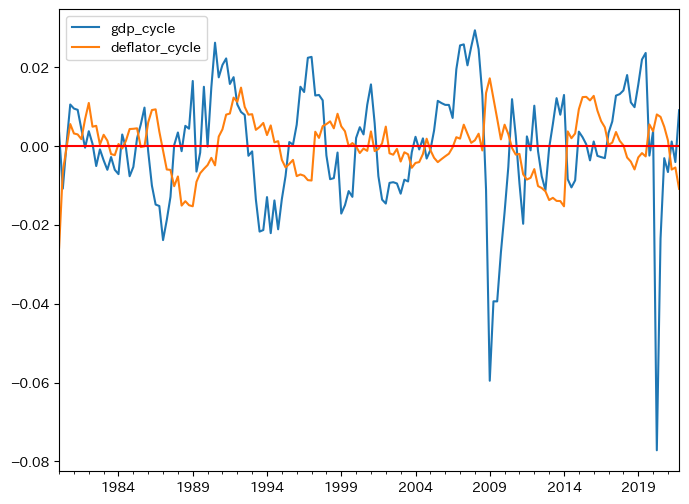

In [2]:
df = py4macro.data('jpn-q')

for c in ['gdp','deflator']:    
    df[c+'_cycle'] = np.log(df[c]) - py4macro.trend( np.log(df[c]) )

ax_ = df.loc[:,['gdp_cycle','deflator_cycle']].plot(figsize=(8,6))
ax_.axhline(0, color='red');

データの特徴１

In [3]:
y_std = df.loc[:,'gdp_cycle'].std()
p_std = df.loc[:,'deflator_cycle'].std()
print(f'GDPのトレンドからの％乖離の標準偏差：{y_std:.6f}')
print(f'デフレータのトレンドからの％乖離の標準偏差：{p_std:.6f}')

GDPのトレンドからの％乖離の標準偏差：0.014765
デフレータのトレンドからの％乖離の標準偏差：0.006958


データの特徴２

In [4]:
y_autocorr = df.loc[:,'gdp_cycle'].autocorr()
p_autocorr = df.loc[:,'deflator_cycle'].autocorr()
print(f'GDPのトレンドからの％乖離の自己相関係数：{y_autocorr:.3f}')
print(f'デフレータのトレンドからの％乖離の自己相関係数：{p_autocorr:.3f}')

GDPのトレンドからの％乖離の自己相関係数：0.681
デフレータのトレンドからの％乖離の自己相関係数：0.829


データの特徴３

In [5]:
yp_corr = df.loc[:,['gdp_cycle', 'deflator_cycle']].corr().iloc[0,1]
print(f'GDPとデフレータの％乖離の相関係数：{yp_corr:.3f}')

GDPとデフレータの％乖離の相関係数：-0.234


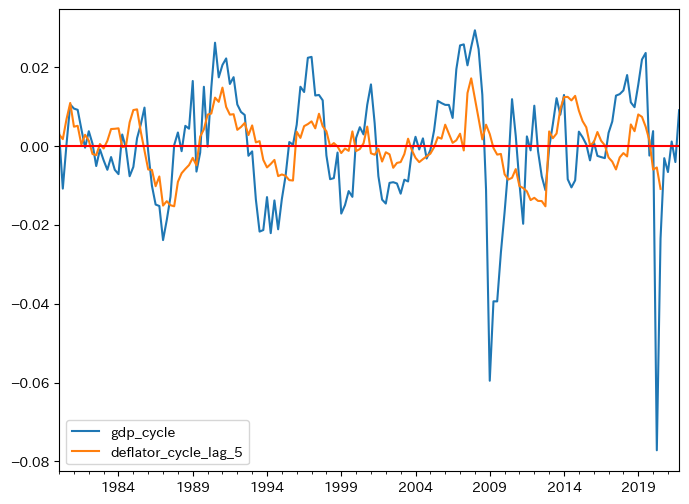

In [59]:
tmp = df.copy()
tmp['deflator_cycle_lag_5'] = tmp['deflator_cycle'].shift(-5)
# tmp.iloc[:6, -3:]
ax_ = tmp.loc[:,['gdp_cycle','deflator_cycle_lag_5']].plot(figsize=(8,6))
ax_.axhline(0, color='red');

## カリブレーション 

データに基づき，モデルの次の4つのパラメーターの値を決めていく
* $a$，$c$，$\sigma_u$，$\sigma_v$ （標準偏差）

パラメーターの値の決め方には主に次の２つある。
1. データに基づいて計量経済学的な手法などを用いて推定した結果を使う。
1. 既存の実証研究で報告され推定値を使う。

### カリブレーションとは

２つの体重計があるとしよう。
* 市販の正確な体重計で誤差はない。
* もう一つは自作の体重計で，作ったばかりなので精度に欠ける。
    * 精度を高めるためにスイッチが取り付けられている。
    
基準となる機器に基づいて測定器の誤差をなくすための調整をおこなうことを**カリブレーション**と呼ぶ。

AD-ASモデルに応用する。
* 市販の正確な体重計　→　日本経済
* 手作り体重計　→　ADASモデル
* 手作り体重計のスイッチ　→　ADASモデルのパラメーター（外生変数）
* スイッチの調整　→　パラメーターの値の設定
* カリブレーションで使うデータ
    * 自分の体重　→　景気循環に関するデータ
* 評価方法
    * 他の人の体重を測り手作り体重計の誤差を確認　→　ADASモデルのパラメーターの設定に使われていないデータの特徴１〜３をどれだけ説明できるかの確認

### スイッチの調整のための準備

$$\begin{align*}
y_t&=-c p_t + u_t\tag{AD曲線}\\
p_{t}&=p_{t-1}+ay_{t}+v_{t} \tag{AS曲線}
\end{align*}$$

(AD曲線) → (AS曲線)（$y_t$をなくす）

$$
p_{t}
=h p_{t-1}+e_{pt}
\tag{回帰式１}
$$

ここで

$$
h\equiv\frac{1}{1+a c}<1,
\qquad\quad
e_{pt}\equiv h\left(a u_{t}+v_{t}\right)
$$

回帰分析に基づいて$h$の推定値求める。

`df`のメソッド`.shift()`を使って`deflator_cycle`を１期ずらした列を`deflator_cycle_lag`として`df`に追加

In [6]:
df['deflator_cycle_lag'] = df['deflator_cycle'].shift()

df.iloc[:3,-5:]

,price,deflator,gdp_cycle,deflator_cycle,deflator_cycle_lag
,,,,,
1980-03-31,71.015699,91.2,0.003269,-0.025798,NaN
1980-06-30,72.907806,93.4,-0.010845,-0.006555,-0.025798
1980-09-30,73.898630,94.4,0.000457,-0.000482,-0.006555


In [7]:
res_h = smf.ols('deflator_cycle ~ -1 + deflator_cycle_lag', data=df).fit()
print(res_h.summary().tables[1])

                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
deflator_cycle_lag     0.8003      0.042     19.121      0.000       0.718       0.883


* `Durbin-Watson`は`1.685`であり残差の系列相関は排除できる。
* AR(1)は弱重属性（weakly dependent）を満たす →  $h$の推定値である$\hat{h}$は一致性を満たす。
* ブルーシュペーガン検定とホワイト検定
    * H0（均一分散）を棄却　→  不均一分散と結論する。
* 不均一頑健推定：推定値`h`の`t`検定は有効　→ 統計的に優位

In [8]:
hhat = res_h.params[0]  # hの推定値
ep = res_h.resid        # 回帰式(1)の残差

### 最初のスイッチ：$c$の値

$$\begin{align*}
y_t&=-c p_t + u_t\tag{AD曲線}\\
p_{t}&=p_{t-1}+ay_{t}+v_{t} \tag{AS曲線}
\end{align*}$$

(AS曲線) → (AD曲線)（$p_t$をなくす）

$$
y_t = dp_{t-1} + e_{yt}
\tag{回帰式２}
$$

ここで

$$
d\equiv -ch,
\qquad\quad
e_{yt}\equiv hu_t-chv_t
$$

回帰分析に基づいて$d$の推定値求める。

In [9]:
res_d = smf.ols('gdp_cycle ~ -1 + deflator_cycle_lag', data=df).fit()
print(res_d.summary().tables[1])

                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
deflator_cycle_lag    -0.5437      0.160     -3.388      0.001      -0.860      -0.227


* `Durbin-Watson`は`0.696`であり正の系列相関が疑われる。
* ブルーシュペーガン検定とホワイト検定：不均一分散の可能性を排除できない
* 不均一系列相関頑健推定（`HAC`）：推定値`h`の`t`検定は有効　→　統計的に優位

In [10]:
dhat = res_d.params[0]  # dの推定値

$-d\equiv ch$となるため

$$
\hat{c} = -\frac{\hat{d}}{\hat{h}}
$$

この値を`chat`に割り当てよう。

In [11]:
chat = -dhat / hhat
chat

0.6792737658050553

In [12]:
ey = res_d.resid        # 回帰式(2)の残差

### ２つ目のスイッチ：$a$の値

$h=\dfrac{1}{1+ac}$となるため

$$
\hat{a} = \left(\dfrac{1}{\hat{h}}-1\right)\frac{1}{\hat{c}}
$$


In [13]:
ahat = (1/hhat - 1) / chat
ahat

0.3672412758026918

### ３つ目と４つ目のスイッチ：$\sigma_v$と$\sigma_u$（ショックの標準偏差）

回帰分析の誤差項の定義に残差（$\hat{e}_{yt}$，$\hat{e}_{pt}$）と推定値（$\hat{a}$，$\hat{c}$）を使う

$$
\begin{align*}
\hat{e}_{yt}&=\hat{h}u_t-\hat{c}\hat{h}v_t\\
\hat{e}_{pt}&=\hat{a}\hat{h}u_{t}+\hat{h}v_{t}
\end{align*}
$$

線形連立方程式として考えて，$u_t$と$v_t$を計算することができる。

$$
\begin{align*}
\hat{u}_t=\hat{c}\hat{e}_{pt}+\hat{e}_{yt}\\
\hat{v}_t=\hat{e}_{pt}-\hat{a}\hat{e}_{yt}
\end{align*}
$$

$\hat{u}_t$と$\hat{v}_t$は$u_t$と$u_t$の推定値。以下では，
* $\hat{u}_t$を計算　→　$\sigma_u$の計算
* $\hat{v}_t$を計算　→　$\sigma_v$の計算

In [14]:
vt = ep - ahat*ey
v_std = vt.std()
v_std

0.006607538577733419

In [15]:
ut = ey + chat*ep
u_std = ut.std()
u_std

0.014412448205984505

## コードの基本形

In [16]:
def my_func(a, n):

    x = 0

    lst = []

    for i in range(n):

        x = x + a

        lst.append(x)
        
    return pd.DataFrame({'col': lst})

In [17]:
my_func(2, 5)

,col
0,2
1,4
2,6
3,8
4,10


## ADASモデルの安定性

$u_t=v_t=0$，$t=0,1,2,\cdots$としよう。

$$
p_{t}=hp_{t-1}
\qquad\quad
y_t=-cp_t 
$$

* 任意の初期値から安定性の確認
* 初期値は$p_0$のみで良い

|           | t=0   | t=1   | t=2   | t=3   |... |
|-----------|-------|-------|-------|-------|----|
| デフレーター | $p_0$ | $p_1$ | $p_2$ | $p_3$ |... |
| GDP       | $y_0$ | $y_1$ | $y_2$ | $y_3$ |... |

In [18]:
def adas_model(p0=0, n=20, a=ahat, c=chat):
    """引数
        p0: pの初期値（デフォルト：0）
        n: ループの回数（デフォルト：20）
        a: aの値（デフォルト：ahat）
        c: cの値（デフォルト：chat）
    戻り値：
        yとpのDataFrame"""

    # ========== pの差分方程式の右辺 ==========
    def price_func(p):
        h = 1/(1+a*c)  # hの値
        return h*p
        
    # ========== yの初期値 ==========
    y0 = - c * p0

    # ========== forループのアップデート用変数 ==========
    # yのアップデート用の変数は必要ない
    p = p0
    
    # ========== yとpの値を格納するリスト ==========
    y_list = [y0]
    p_list = [p0]

    # ========== ショック後 ==========
    for _ in range(n):
        p = price_func(p)
        y = -c*p

        y_list.append(y)
        p_list.append(p)
    
    # DataFrameを返す
    dic = {'y':y_list, 'p':p_list}
    
    return pd.DataFrame(dic)

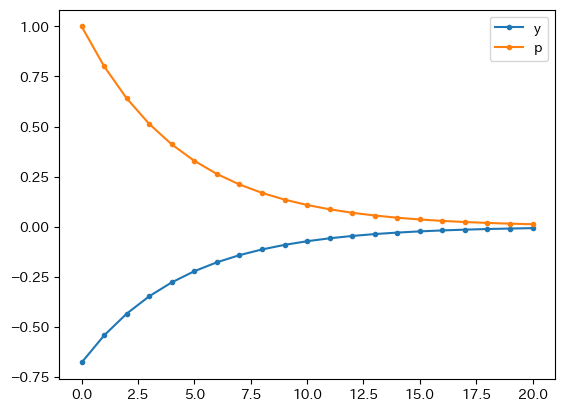

In [19]:
adas_model(p0=1).plot(marker='.')
pass

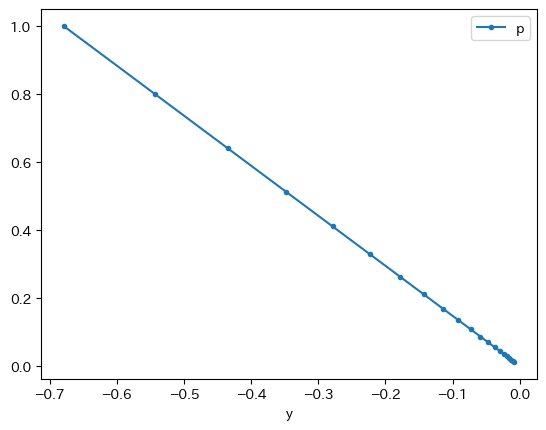

In [20]:
adas_model(p0=1).plot('y', 'p', marker='.')
pass

## インパルス反応関数

インパルス反応関数とは，あるショック（$u_t$もしくは$v_t$）が一定期間（例えば，１期間のみ）発生した場合，`y_t`と`p_t`がどのように変化するかを示す時系列のグラフ

$$
\begin{align*}
p_{t}&=hp_{t-1}+h\left(a u_{t}+v_{t}\right)\tag{AS曲線}\\
y_t&=-cp_t + u_t\tag{AD曲線}
\end{align*}
$$

`adas_model()`関数と異なる主な箇所は`<--- changed/added`で示す。

In [60]:
def one_period_impulse(u=0, v=0, n_after=20, a=ahat, c=chat):
    """引数
        u: AD曲線へのショックの大きさ（デフォルト：0）
        v: AS曲線へのショックの大きさ（デフォルト：0）
        n_after: ショック発生後の期間（デフォルト：20）
        a: aの値（デフォルト：ahat）
        c: cの値（デフォルト：chat）
    戻り値：
        y, p, u, vのDataFrame

    * 最初の３期間はショックゼロ"""

    # ========== pの差分方程式の右辺 ==========
    def price_func(p, u, v):        # <--- changed
        h = 1/(1+a*c)
        return h*p + h*(a*u + v)    # <--- changed
        
    # ========== forループのアップデート用変数 ==========
    # yのアップデート用の変数は必要ない
    p = 0   # 最初は定常状態に設定
    
    # ========== 結果を格納するリストの作成 ==========
    # 最初の３つの要素は定常状態に設定
    y_list = [0]*3     # <--- changed
    p_list = [0]*3     # <--- changed
    u_list = [0]*3     # <--- added
    v_list = [0]*3     # <--- added

    # ========== ショック発生時 ==========
    p = price_func(p, u, v)   # <--- added
    y = - c*p + u             # <--- added
        
    y_list.append(y)          # <--- added
    p_list.append(p)          # <--- added
    u_list.append(u)          # <--- added
    v_list.append(v)          # <--- added
        
    # ========== ショック後 ==========
    u, v = 0, 0                  # <--- added

    for _ in range(n_after):     # <--- changed
        p = price_func(p, u, v)  # <--- changed
        y = - c*p + u            # <--- changed

        y_list.append(y)
        p_list.append(p)
        u_list.append(u)      # <--- added
        v_list.append(v)      # <--- added
    
    # 変数の辞書
    dic = {'y':y_list, 'p':p_list, 'u':u_list, 'v':v_list}  # <--- changed
    
    return pd.DataFrame(dic)

### 総供給ショック（$v_t$）

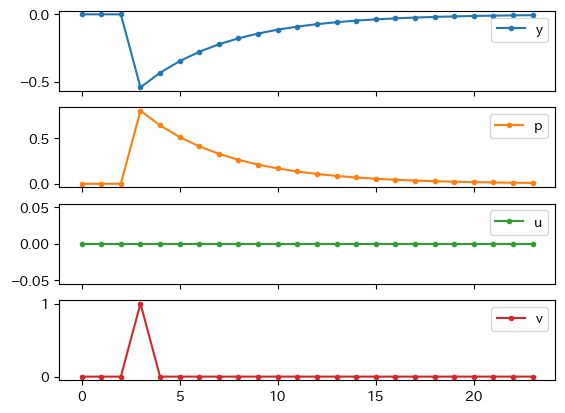

In [22]:
one_period_impulse(v=1).plot(subplots=True, marker='.')
pass

<img src="./figure/adas1.jpeg" width="60%">

### 総需要ショック（$u_t$）

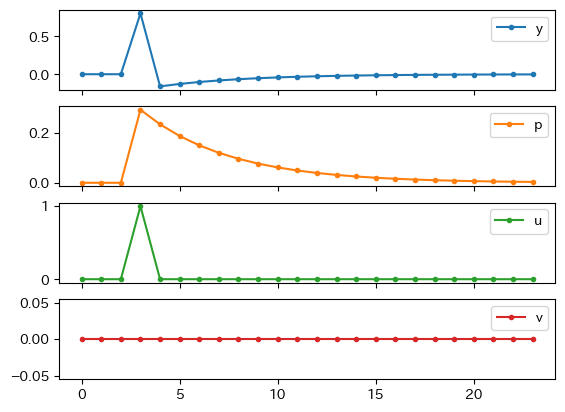

In [23]:
one_period_impulse(u=1).plot(subplots=True, marker='.')
pass

<img src="./figure/adas2.jpeg" width="60%">

### 総供給ショック＋総需要ショック

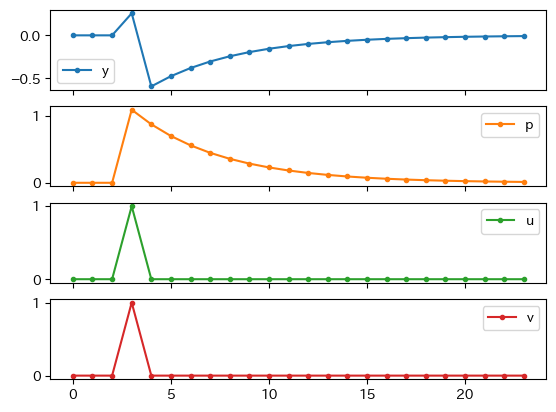

In [24]:
one_period_impulse(u=1, v=1).plot(subplots=True, marker='.')
pass

<img src="./figure/adas3.jpeg" width="60%">

## 確率的シミュレーション

毎期`u`，`v`にランダムな値を割り当てシミュレーションをおこなう。
* $u_t\sim\text{Normal}(0,\sigma_u^2)$
* $v_t\sim\text{Normal}(0,\sigma_v^2)$

ここで
$$
\sigma_u=\text{u_std},
\qquad\quad
\sigma_v=\text{v_std}
$$

`one_period_impulse()`関数と異なる主な箇所は`<--- changed/added`で示す。

    """引数
        u: AD曲線へのショックの大きさ（デフォルト：0）
        v: AS曲線へのショックの大きさ（デフォルト：0）
        n_after: ショック発生後の期間（デフォルト：20）
        a: aの値（デフォルト：ahat）
        c: cの値（デフォルト：chat）
    戻り値：
        y, p, u, vのDataFrame

    * 最初の３期間はショックゼロ"""


In [25]:
def stochastic_sim(n=100, a=ahat, c=chat, ustd=u_std, vstd=v_std):
    """引数
        n: シミュレーションの回数（デフォルト：100）    <--- added
        a: aの値（デフォルト：ahat）
        c: cの値（デフォルト：chat）
        ustd: 需要ショックの分散（デフォルト：u_var）  <--- changed
        vstd: 供給ショックの分散（デフォルト：v_var）) <--- changed
    戻り値：
        y, p, u, vのDataFrame
        """
    # ========== pの差分方程式の右辺 ==========
    def price_func(p, u, v):
        h = 1/(1+a*c)
        return h*p + h*(a*u + v)
    
    # ========== forループのアップデート用変数 ==========
    # yのアップデート用の変数は必要ない
    p = 0   # 最初は定常状態に設定

    # ========== 結果を格納するリストの作成 ==========
    y_list = []    # <--- changed
    p_list = []    # <--- changed
    u_list = []    # <--- changed
    v_list = []    # <--- changed

    # ========== ループ計算 ==========
    rng = np.random.default_rng()    # <--- added
    for _ in range(n):               # <--- changed
        
        # ADのショック項
        u = rng.normal(0, ustd)      # <--- added

        # ASのショック項
        v = rng.normal(0, vstd)      # <--- added
        
        p = price_func(p, u, v)
        y = - c*p + u
            
        y_list.append(y)
        p_list.append(p)
        u_list.append(u)
        v_list.append(v)
            
    # 変数の辞書の作成
    dic = {'y':y_list, 'p':p_list, 'u':u_list, 'v':v_list}

    # DataFrameを返す
    return pd.DataFrame(dic)

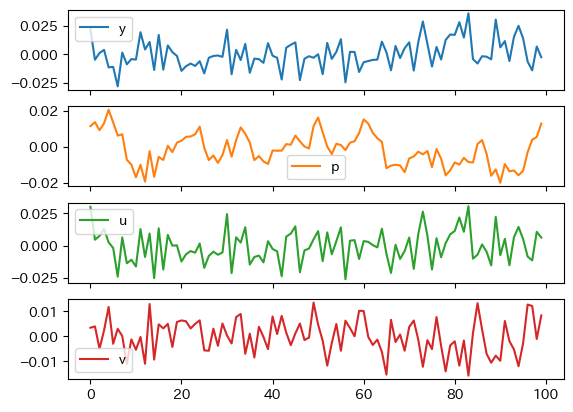

In [26]:
sim = stochastic_sim(n=100)
sim.plot(subplots=True)
pass

## データの特徴１〜３を再現できるか

統計量の計算のために`n=1_000_000`を使う。

In [27]:
sim = stochastic_sim(n=1_000_000)

### GDPと価格水準の％乖離の標準偏差

データの値

In [28]:
print(f'GDPのトレンドからの％乖離の標準偏差：{y_std:.5f}')
print(f'デフレータのトレンドからの％乖離の標準偏差：{p_std:.5f}')

GDPのトレンドからの％乖離の標準偏差：0.01477
デフレータのトレンドからの％乖離の標準偏差：0.00696


シミュレーションの結果

In [29]:
for value in ['y','p']:
    print(f'{value}の標準偏差:{sim[value].std():.5f}')

yの標準偏差:0.01354
pの標準偏差:0.01130


### 自己相関係数

データの値

In [30]:
print(f'GDPのトレンドからの％乖離の自己相関係数：{y_autocorr:.3f}')
print(f'デフレータのトレンドからの％乖離の自己相関係数：{p_autocorr:.3f}')

GDPのトレンドからの％乖離の自己相関係数：0.681
デフレータのトレンドからの％乖離の自己相関係数：0.829


シミュレーションの結果

In [31]:
for value in ['y','p']:
    print(f'{value}:{sim[value].autocorr():.3f}')

y:0.075
p:0.800


### `p`と`y`の％乖離の相関係数

データの値

In [32]:
df.loc[:,['gdp_cycle', 'deflator_cycle']].corr().iloc[0,1]

-0.23397833650523714

シミュレーションの結果

In [33]:
sim[['y', 'p']].corr().iloc[0,1]

-0.16681818320709785

### 結果のまとめ

|             | GDP標準偏差 | デフレータの標準偏差 | GDP自己相関係数 | デフレータの自己相関係数| GDPとデフレータの相関係数|
|-------------|-----------|--------------|-------------- |----------------|---------|
|データ        |  0.01477    | 0.00696        |  0.681        |    0.829       |  -0.234  |
|WNショック    |  0.01356    | 0.01128       |  0.075       |  0.800         |  -0.166 |
|AR(1)ショック | 0.01252     | 0.01707        |  0.649        |  0.931        |  -0.292   |
|状態空間モデル | 0.01462     | 0.00675        |  0.675        |  0.850        |  -0.229   |

捉えることができていないデータの特徴もあるが，全く的外れな結果ではない。

### 総需要・総供給ショックが`AR(1)`の場合

* ホワイト・ノイズは前期のショックと今期のショックは何の関係もない独立を意味する。
* ある程度の**持続性**が存在すると想定できる。
    * 政府：増税を実施すると，１四半期後に減税するような行動は取らない。少なくともある期間，政策を一貫して実施することになる。
    * 投資：１四半期毎に企業は投資をコロコロと変えるような行動はしない。
    * 消費：嗜好の変化も需要ショックとして現れるが，ファッションで今季は赤が流行り，１四半期後には青が流行るということではない。
    * 総供給ショック（例えば，オイルショックやウクライナでの戦争によるサプライ・チェーン問題）も同じように考えることができる。

$$
\begin{align*}
u_t&=\rho_u u_{t-1}+e^u_t,\qquad e^u_t\sim\text{WN}(0,\sigma_{eu}^2)\\
v_t&=\rho_v v_{t-1}+e^v_t,\qquad e^v_t\sim\text{WN}(0,\sigma_{ev}^2)
\end{align*}
$$

推定するパラメータ：
* $a$, $c$, $\rho_u$，$\rho_v$，$\sigma_{eu}^2$，$\sigma_{ev}^2$

このように計算すると次の値となる。
* $\hat{\rho}_u=0.688$
* $\hat{\rho}_v=0.313$
* $\hat{\sigma}_{eu}=0.01042$
* $\hat{\sigma}_{ev}=0.00604$

### ADASモデルの評価：２つの推論方法

#### 帰納的推論（inductive inference）
* 真のモデルが存在するという前提の下でデータを使い推定するモデルの蓋然性を検討する手法
* 典型的な例として，計量経済分析
* 推定されたモデルは，帰納的推論の**アウトプット**
　
<br>
　
<img src="./figure/inductive2.png" width="70%">

#### 演繹的推論（deductive inference）
* モデルは**インプット**
* モデルを「装置」として使い，理論の含意に関して推論する
    * 例えば，AD-ASモデルで比較静学をおこない，外生変数の定性的な効果を検討する場合が当てはまる。
* 経済モデルは複雑な経済を抽象化した考え方に過ぎず，「間違った」モデルである。
    * 例えば，消費者モデル：根本的な側面を捉えているだろうが，全てを説明はできない。
    * AD-ASモデルが真のモデルかどうかを判断しようということではない。
    * モデルは地図のようなものであり，目的に沿ったものであれば良い。完璧でなくても良い。　

<br>
　
<img src="./figure/deductive.png" width="70%">
　
<br>

　AD-ASモデルをインプット（「装置」）として使い**定量的**な問を検討する。

## 定量的な問

> GDPと価格水準の％乖離の変動は，何パーセントが需要ショックにより引き起こされ，何パーセントが供給ショックに起因するのか？

### 予測誤差

カリブレーションをおこなった際の推定式を考えよう。

$$
\begin{align*}
y_{t} &= -chp_{t-1} + e_{yt}\qquad e_{yt}\equiv h(u_{t}-cv_{t})\\
p_{t}&=hp_{t-1} + e_{pt}\qquad e_{pt}\equiv h\left(a u_{t}+v_{t}\right)
\end{align*}
$$

今期が`t-1`期とし，$x_{t-1}$は既に実現したとしよう。`t`期の変数は実現前の将来の変数である。ここで，実現値$x_t$を所与として`t`期の変数を予測するとしよう。予測値は

$$
\begin{align*}
\text{E}_{t-1}(y_{t}) &= -chp_{t-1}
\qquad\because \text{E}_{t-1}(e_{yt})=0
\\
\text{E}_{t-1}(p_{t})&=hp_{t-1}
\qquad\because \text{E}_{t-1}(e_{pt})=0
\end{align*}
$$

従って，予測誤差は

$$
\begin{align*}
y_{t} - \text{E}_{t-1}(y_{t})&= e_{yt}\\
p_{t}- \text{E}_{t-1}(p_{t})&= e_{pt}
\end{align*}
$$

* 予測誤差は総需要ショックと総供給ショックによって発生した$y_t$と$p_t$の変動を捉えており，両方の影響が混在する。

### 予測誤差の分散分解：考え方

1. ショックによって引き起こされた景気循環（$y_t$と$p_t$のトレンドからの％乖離）を$e_{yt}$と$e_{pt}$の**分散**として捉える。
1. $e_{yt}$と$e_{pt}$の分散を総需要ショックと総供給ショックに起因する分散に分解する。


$$
\text{Var}(e_{xt})=\text{Var}(e_{xt}|u_t)+\text{Var}(e_{xt}|v_t)
\qquad
x_t=y_t,p_t
$$

* $\text{Var}(e_{xt})$：$x_t$の分散
* $\text{Var}(e_{xt}|u_t)$：総需要ショック（$u_t$）に起因する$x_t$の分散
* $\text{Var}(e_{xt}|v_t)$：総供給ショック（$v_t$）に起因する$x_t$の分散

この関係を使うと

$$
\begin{align*}
\left(
\begin{split}
&\text{総需要ショックによる}\\
&x_t\text{の変動の割合}
\end{split}
\right)
&=
\frac{\text{Var}(e_{xt}|u_t)}{\text{Var}(e_{xt})},
\qquad
x_t=y_t,p_t
\\
\left(
\begin{split}
&\text{総供給ショックによる}\\
&x_t\text{の変動の割合}
\end{split}
\right)
&=
\frac{\text{Var}(e_{xt}|v_t)}{\text{Var}(e_{xt})},
\qquad
x_t=y_t,p_t
\end{align*}
$$

それぞれの項を計算し**量的な問い**を考察する。

### GDPの％乖離

$$
\begin{align*}
\left(
\begin{split}
&\text{需要ショックによる}\\
&y_t\text{の変動の割合}
\end{split}
\right)
&
=\frac{\sigma_u^2-c\sigma_{uv}}
    {\sigma_u^2+
    c^2\sigma_v^2-
    2c\sigma_{uv}}
\tag{ADshockY}
\end{align*}
$$

$$
\begin{align*}
\left(
\begin{split}
&\text{供給ショックによる}\\
&y_t\text{の変動の割合}
\end{split}
\right)
&
=\frac{c^2\sigma_v^2-c\sigma_{uv}}
    {\sigma_u^2+
    c^2\sigma_v^2-
    2c\sigma_{uv}}
\tag{ASshockY}
\end{align*}
$$

導出は授業ノートブックを参照

In [34]:
# 式(ADshockY)と(ADshockP)の分母
denominator_y = ut.var() + chat**2*vt.var() - 2*chat*np.cov(ut,vt)[0,1]

In [35]:
# 式(ADshockY)の分子
numerator_y = ut.var() - chat*np.cov(ut,vt)[0,1]

In [36]:
ad_shock_on_y = numerator_y / denominator_y
print(f'GDPの％乖離の{100*ad_shock_on_y:.1f}％は需要ショックに起因する。'  )

GDPの％乖離の79.3％は需要ショックに起因する。


In [37]:
print(f'GDPの％乖離の{100*(1-ad_shock_on_y):.1f}％は供給ショックに起因する。'  )

GDPの％乖離の20.7％は供給ショックに起因する。


GDPの％乖離に対しては総需要ショックが相対的に大きな影響を及ぼしている。
* $0.0144\approx\sigma_u>\sigma_v\approx 0.0066$
* $c\approx 0.680$が大きな役割：総需要曲線の傾きは $1/c\approx 1.47$
    * $1/c$ が大きい場合，総需要曲線の傾きは急　→　総供給曲線が動くと$y_t$の動きは小さい　→　総供給ショックのインパクトは小さくなる
    * $1/c$ が小さい場合，総需要曲線の傾きは緩やか　→　総供給曲線が動くと$y_t$の動きは大きい　→　総供給ショックのインパクトは大きくなる

$1/c>1$　→　総供給ショックのインパクトは小さくなり，相対的に総需要ショックのインパクトは大きくなっている

<img src="./figure/adas4.jpeg" width="60%">

### 価格水準の％乖離

$$
\begin{align*}
\left(
\begin{split}
&\text{需要ショックによる}\\
&p_t\text{の変動の割合}
\end{split}
\right)
&
=\frac{a^2\sigma_u^2+a\sigma_{uv}}
    {a^2\sigma_u^2+
    \sigma_v^2+
    2a\sigma_{uv}}
\tag{ADshockP}
\end{align*}
$$

$$
\begin{align*}
\left(
\begin{split}
&\text{供給ショックによる}\\
&p_t\text{の変動の割合}
\end{split}
\right)
&
=\frac{\sigma_v^2+a\sigma_{uv}}
    {a^2\sigma_u^2+
    \sigma_v^2+
    2a\sigma_{uv}}
\tag{ASshockP}
\end{align*}
$$

導出は講義ノートブックを参照

In [38]:
# 式(ADshockP)と(ASshockP)の分母
denominator_p = ahat**2*ut.var() + vt.var() + 2*ahat*np.cov(ut,vt)[0,1]

In [39]:
# 式(ADshockP)の分子
numerator_p = ahat**2*ut.var() + ahat*np.cov(ut,vt)[0,1]

In [40]:
ad_shock_on_p = numerator_p / denominator_p
print(f'価格水準の％乖離の{100*ad_shock_on_p:.1f}％は需要ショックに起因する。'  )

価格水準の％乖離の14.1％は需要ショックに起因する。


In [41]:
print(f'価格水準の％乖離の{100*(1-ad_shock_on_p):.1f}％は供給ショックに起因する。'  )

価格水準の％乖離の85.9％は供給ショックに起因する。


デフレーターの％乖離に対しては総供給ショックが相対的に大きな影響を及ぼしている。
* $0.0144\approx\sigma_u>\sigma_v\approx 0.0066$
* $a\approx 0.367$が大きな役割：総供給曲線の傾きは $a$
    * $a$ が小さい場合，総供給曲線の傾きは緩やか　→　総需要曲線が動くと$y_t$の動きは大きいが，$p_t$の動きは小さい
    * $a$ が大きい場合，総供給曲線の傾きは急　→　総需要曲線が動くと$y_t$の動きは小さいが，$p_t$の動きは大きい

$a<1$　→　総供給ショックのインパクトは大きくなり，相対的に総需要ショックのインパクトは小さくなっている

<img src="./figure/adas5.jpeg" width="60%">

## まとめ

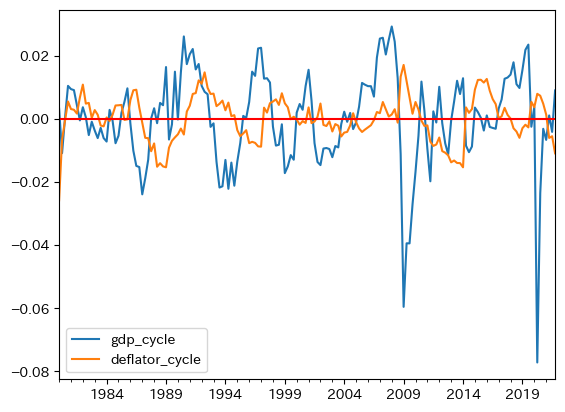

In [42]:
ax_ = df.loc[:,['gdp_cycle','deflator_cycle']].plot()
ax_.axhline(0, color='red')
pass

このプロットを眺めるだけでは，定量的な問いに答えることはできない。AD-ASモデルを「装置」として用いて，「スイッチ」を調整することにより，結果が数字として現れてくることになる。

体重計の例をもう一度考えてみよう。今度は，AさんとBさんが作る体重計である。
* Aさんの体重計は単純な装置
* Bさんの技術は高く，設計図は洗練され使う材料もより質が高い

その差は精度の違いとして現れることになるだろう。

マクロ経済モデルも同じである。AD-ASモデルは，研究や政策議論で使われるモデルと比べると単純なモデルであり，それが故に定量的な問に対しての答えも精度が低いものとならざるを得ない。大学院で学ぶDSGEモデルや構造VARモデルなどはより洗練された「装置」であり，AD-ASモデルよりも精度が高いと期待される。